In [1]:
# Instalar las librerías necesarias para el procesamiento de lenguaje natural con transformers y datasets
%pip install -q transformers datasets 
# Instalar transformers con soporte para PyTorch
%pip install transformers[torch]

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importar librerías básicas para manipulación de datos y visualización
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

# Importar herramientas de scikit-learn para división de datos y métricas de evaluación
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

# Importar componentes de transformers para el modelo BERT y entrenamiento
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)
# Importar Dataset de la librería datasets para manejar los datos
from datasets import Dataset

In [3]:
# Cargar el dataset de reseñas desde un archivo CSV
df = pd.read_csv(r"C:\Users\arbed\Downloads\dataset_sentimientos_500.csv")
# Limpiar los nombres de las columnas eliminando espacios en blanco
df.columns = df.columns.str.strip()
# Seleccionar solo las columnas relevantes y eliminar filas con valores nulos
df = df[['Reseña', 'Sentimiento']].dropna()

# Mapear las etiquetas de sentimiento a valores numéricos: Positiva -> 1, Negativa -> 0
df['Sentimiento'] = df['Sentimiento'].map({'Positiva': 1, 'Negativa': 0})

# Verificar si hay etiquetas no mapeadas y lanzar error si es necesario
if df['Sentimiento'].isna().any():
    raise ValueError("Hay etiquetas no mapeadas (distintas a Positiva/Negativa). Revisa el CSV.")

# Contar la distribución de clases
class_counts = df['Sentimiento'].value_counts()
# Calcular la longitud de las reseñas en palabras
lengths = df['Reseña'].astype(str).apply(lambda s: len(s.split()))

# Imprimir análisis de variables
print("\n## Análisis de variables")
print("Distribución de clases:\n", class_counts)
print("\nLongitud de reseñas (palabras):")
display(lengths.describe())


## Análisis de variables
Distribución de clases:
 Sentimiento
1    250
0    250
Name: count, dtype: int64

Longitud de reseñas (palabras):


count    500.000000
mean       6.020000
std        1.412654
min        4.000000
25%        5.000000
50%        6.000000
75%        7.000000
max       10.000000
Name: Reseña, dtype: float64

In [4]:
# Dividir los datos en conjuntos de entrenamiento y prueba
# Convertir las reseñas a listas de strings y las etiquetas a listas
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Reseña'].astype(str).tolist(),
    df['Sentimiento'].tolist(),
    test_size=0.3,  # 30% para prueba
    random_state=42,  # Semilla para reproducibilidad
    stratify=df['Sentimiento']  # Mantener proporción de clases
)

In [5]:
# Cargar el tokenizador preentrenado de BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Definir la longitud máxima de las secuencias
MAX_LEN = 128
# Tokenizar los textos de entrenamiento con truncamiento y padding
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=MAX_LEN)
# Tokenizar los textos de prueba
test_encodings  = tokenizer(test_texts,  truncation=True, padding=True, max_length=MAX_LEN)

In [6]:
# Crear el dataset de entrenamiento a partir de los encodings y etiquetas
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

# Crear el dataset de prueba
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels
})

In [7]:
# Definir función para calcular métricas de evaluación durante el entrenamiento
def compute_metrics(eval_pred):
    # Extraer logits y etiquetas de las predicciones
    logits, labels = eval_pred
    # Obtener las predicciones tomando el argmax
    preds = np.argmax(logits, axis=-1)

    # Calcular precisión, recall, f1 y soporte para clasificación binaria
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary', zero_division=0
    )
    # Calcular accuracy
    acc = accuracy_score(labels, preds)
    # Retornar las métricas
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [8]:
# Cargar el modelo BERT preentrenado para clasificación de secuencias con 2 etiquetas
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Configurar los argumentos de entrenamiento para el modelo
training_args = TrainingArguments(
    output_dir="results",  # Directorio para guardar los resultados
    num_train_epochs=3,  # Número de épocas de entrenamiento
    per_device_train_batch_size=8,  # Tamaño del batch para entrenamiento
    per_device_eval_batch_size=8,  # Tamaño del batch para evaluación

    eval_strategy ="epoch",  # Estrategia de evaluación: al final de cada época
    logging_strategy="steps",  # Estrategia de logging: cada ciertos pasos
    logging_steps=10,  # Pasos entre logs

    save_strategy="no",  # No guardar checkpoints
    report_to="none"  # No reportar a ningún servicio externo
)

In [10]:
# Crear el objeto Trainer con el modelo, argumentos y datasets
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Ejecutar el entrenamiento
trainer.train()

c:\Users\arbed\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.081000,0.010792,1.000000,1.000000,1.000000,1.000000
2,0.001100,0.000564,1.000000,1.000000,1.000000,1.000000
3,0.000700,0.000444,1.000000,1.000000,1.000000,1.000000


c:\Users\arbed\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\arbed\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=132, training_loss=0.10840758591957363, metrics={'train_runtime': 124.2917, 'train_samples_per_second': 8.448, 'train_steps_per_second': 1.062, 'total_flos': 10252081161000.0, 'train_loss': 0.10840758591957363, 'epoch': 3.0})

In [11]:
# Imprimir los resultados de evaluación
print("\n## Resultados")
# Evaluar el modelo en el conjunto de prueba
results = trainer.evaluate()
# Mostrar los resultados
display(results)


## Resultados


c:\Users\arbed\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.00044365759822539985,
 'eval_accuracy': 1.0,
 'eval_f1': 1.0,
 'eval_precision': 1.0,
 'eval_recall': 1.0,
 'eval_runtime': 2.304,
 'eval_samples_per_second': 65.104,
 'eval_steps_per_second': 8.247,
 'epoch': 3.0}

In [12]:
# Obtener las predicciones del modelo en el conjunto de prueba
pred_out = trainer.predict(test_dataset)
# Convertir las predicciones a etiquetas binarias
test_preds = np.argmax(pred_out.predictions, axis=-1)

# Imprimir el reporte de clasificación por clase
print("\n### Reporte por clase")
print(classification_report(test_labels, test_preds, target_names=["Negativa(0)", "Positiva(1)"], digits=4))

c:\Users\arbed\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



### Reporte por clase
              precision    recall  f1-score   support

 Negativa(0)     1.0000    1.0000    1.0000        75
 Positiva(1)     1.0000    1.0000    1.0000        75

    accuracy                         1.0000       150
   macro avg     1.0000    1.0000    1.0000       150
weighted avg     1.0000    1.0000    1.0000       150



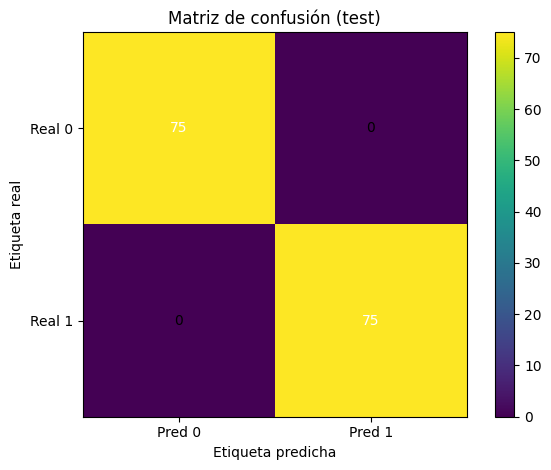

In [13]:
# Calcular la matriz de confusión
cm = confusion_matrix(test_labels, test_preds, labels=[0, 1])

# Crear la figura para la matriz de confusión
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de confusión (test)")
plt.colorbar()
plt.xticks([0, 1], ["Pred 0", "Pred 1"])
plt.yticks([0, 1], ["Real 0", "Real 1"])

# Determinar el umbral para el color del texto
thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
# Agregar los valores de la matriz en la imagen
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("Etiqueta real")
plt.xlabel("Etiqueta predicha")
plt.tight_layout()
plt.show()

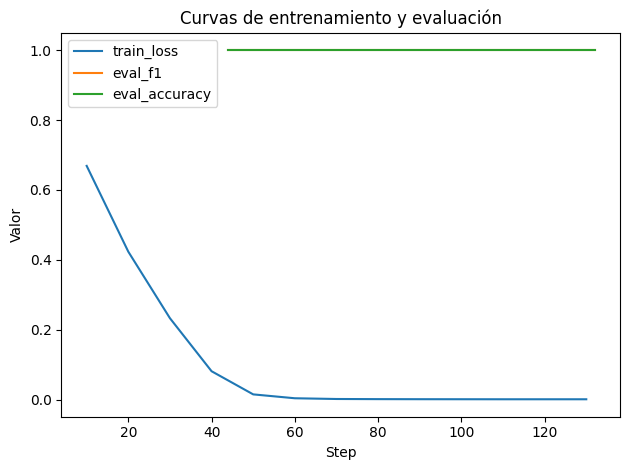

In [14]:
# Obtener el historial de logs del entrenador
log_history = trainer.state.log_history

# Inicializar listas para almacenar los datos de las curvas
steps = []
train_loss = []
eval_steps = []
eval_f1 = []
eval_acc = []

# Procesar el historial de logs para extraer los valores
for item in log_history:
    if "loss" in item and "step" in item and "learning_rate" in item:
        steps.append(item["step"])
        train_loss.append(item["loss"])
    if "eval_f1" in item and "eval_accuracy" in item and "step" in item:
        eval_steps.append(item["step"])
        eval_f1.append(item["eval_f1"])
        eval_acc.append(item["eval_accuracy"])

# Crear la figura para las curvas
plt.figure()
if len(steps) > 0:
    plt.plot(steps, train_loss, label="train_loss")
if len(eval_steps) > 0:
    plt.plot(eval_steps, eval_f1, label="eval_f1")
    plt.plot(eval_steps, eval_acc, label="eval_accuracy")
plt.title("Curvas de entrenamiento y evaluación")
plt.xlabel("Step")
plt.ylabel("Valor")
plt.legend()
plt.tight_layout()
plt.show()